### WORKING CODE with backtest - individiual tickers - mini

Adding data for ticker: ACAD
Adding data for ticker: ADMA
Adding data for ticker: ADPT
Adding data for ticker: AGEN
Adding data for ticker: AGIO
Adding data for ticker: ALKS
Adding data for ticker: ALLK
Adding data for ticker: ALLO
Adding data for ticker: ALNY
Adding data for ticker: AMGN
Adding data for ticker: AMRN
Adding data for ticker: APLS
Adding data for ticker: ARGX
Adding data for ticker: ARWR
Adding data for ticker: ATRA
Adding data for ticker: AUPH
Adding data for ticker: AVDL
Adding data for ticker: AVXL
Adding data for ticker: AXSM
Adding data for ticker: AZN
Adding data for ticker: BCRX
Adding data for ticker: BGNE
Adding data for ticker: BIIB
Adding data for ticker: BLUE
Adding data for ticker: BMRN
Adding data for ticker: CARA
Adding data for ticker: CBAY
Adding data for ticker: CGC
Adding data for ticker: CHRS
Adding data for ticker: CORT
Adding data for ticker: CPRX
Adding data for ticker: CRSP
Adding data for ticker: CYRX
Adding data for ticker: CYTK
Adding data for 



































































































































































































































































































































































































































































































































































































































100%|██████████| 9540/9540 [02:22<00:00, 67.11it/s]
ERROR:root:Error generating QuantStats report for strategy buy_and_hold_strategy: list index out of range
ERROR:root:Error generating QuantStats report for strategy close_vs_sma_strategy: list index out of range
ERROR:root:Error generating QuantStats report for strategy mean_reversion_strategy: list index out of range
ERROR:root:Error g

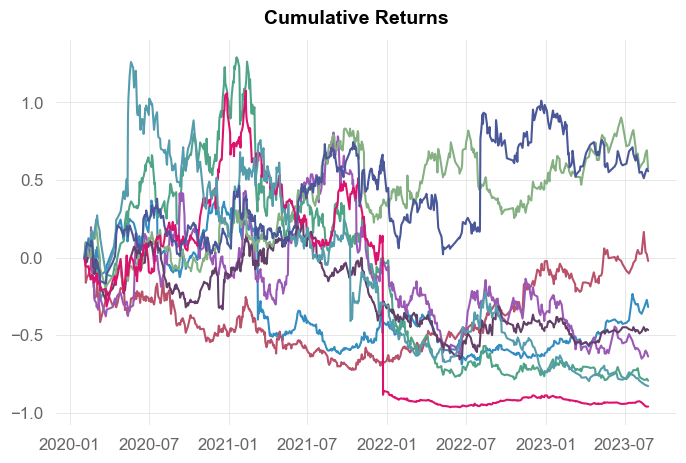

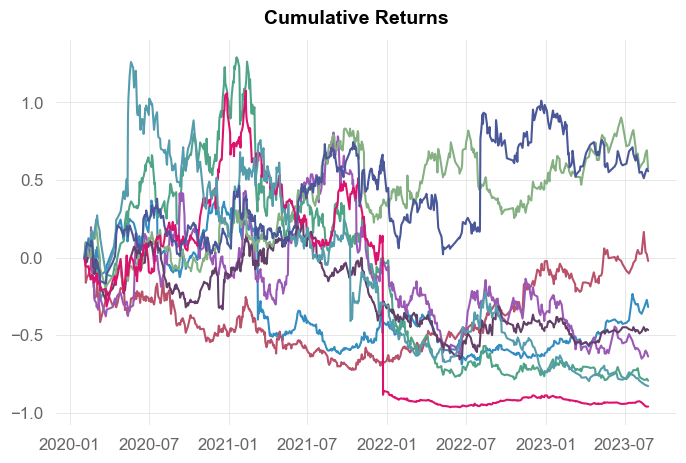

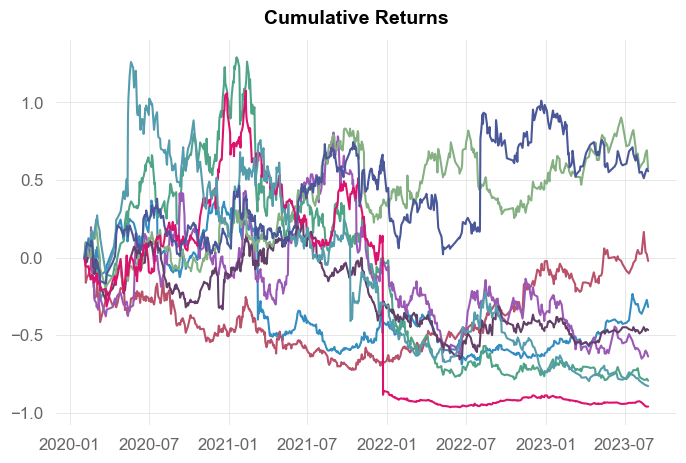

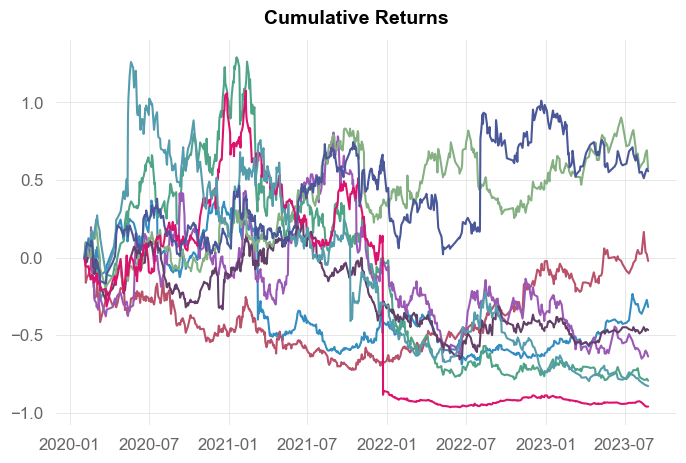

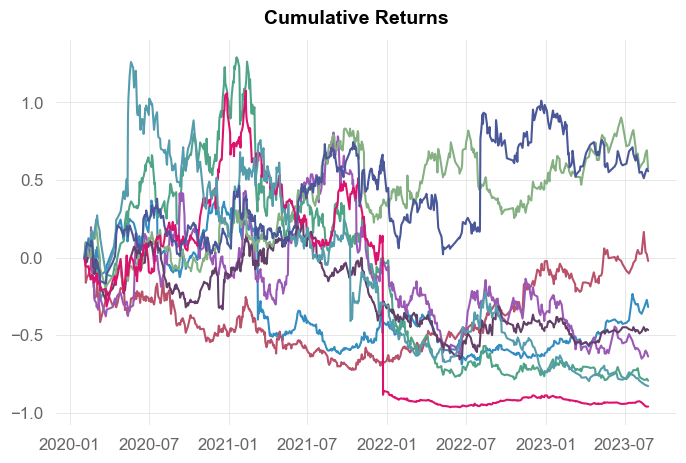

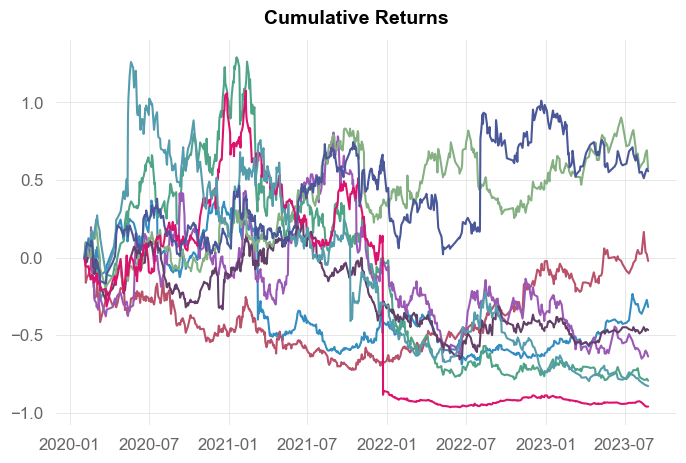

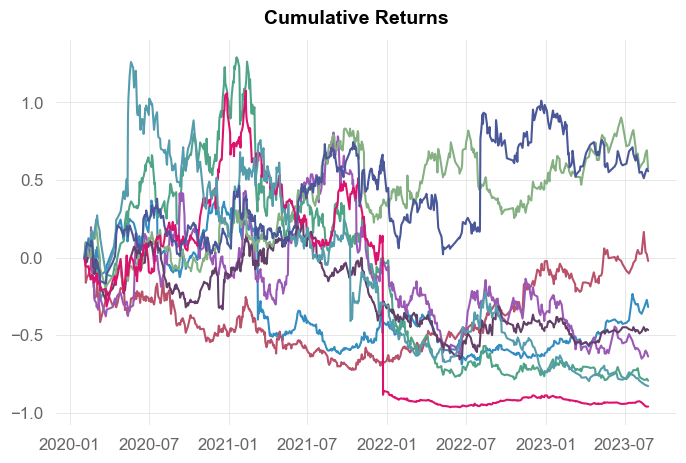

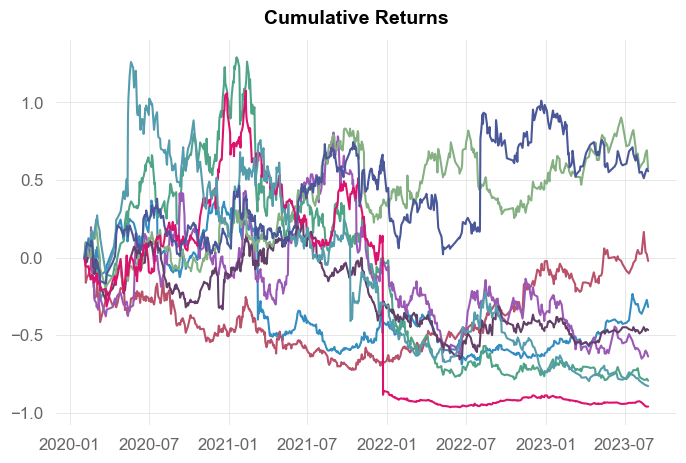

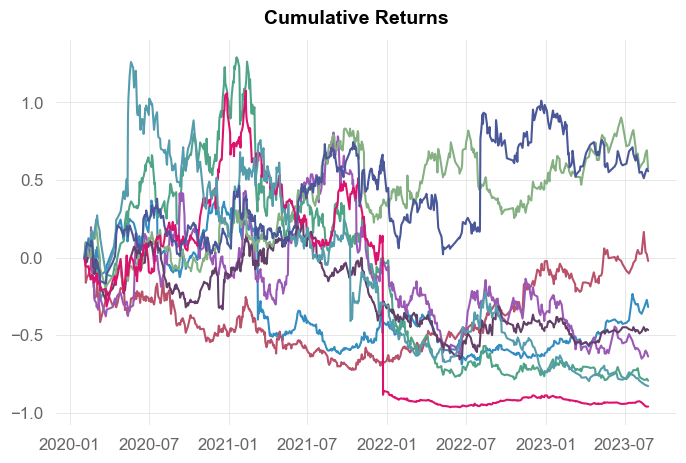

In [24]:
import sqlite3
import pandas as pd
import logging
import backtrader as bt
import quantstats as qs
import os
from bt_strategy import (
    evaluate_strategies,
    buy_and_hold_strategy,
    close_vs_sma_strategy,
    mean_reversion_strategy,
    prev_peak_strategy,
    random_strategy,
    prev_peak_nodrop_strategy,
    close_vs_sma_nodrop_strategy,
    mean_reversion_nodrop_strategy,
    anti_drop_strategy
)
import warnings
warnings.filterwarnings("ignore")

# Set Pandas option to display all columns
pd.set_option('display.max_columns', None)

# Evaluate strategies with multiple trials and parallel processing
n_trials = 10  # Number of trials per strategy per ticker
n_jobs = -1     # Use all available CPU cores

# Set up logging configuration
logging.basicConfig(level=logging.INFO)

# Define your reporting folder (ensure this exists)
REPORTS_FOLDER = "QuantStats_Reports"
os.makedirs(REPORTS_FOLDER, exist_ok=True)  # Create the folder if it doesn't exist

# Constants
DB_PATH = r"/Users/mukeshwaranbaskaran/Documents/MFE Notes/Term 4/AFP/Code/Download_This_Folder/1_financial_data.db"
START_DATE = '2020-01-01'
END_DATE = '2023-12-31'

# Function to load distinct tickers from the SQLite database
def load_distinct_tickers_from_db():
    """Load distinct tickers from the database within the specified date range."""
    conn = sqlite3.connect(DB_PATH)
    query = """
        SELECT DISTINCT ticker
        FROM merged_data
        WHERE date BETWEEN ? AND ?
    """
    distinct_tickers = pd.read_sql(query, conn, params=(START_DATE, END_DATE))
    conn.close()
    return distinct_tickers

# Load tickers and order alphabetically
tickers = load_distinct_tickers_from_db()

# Assuming the result is a DataFrame, extract the 'ticker' column
tickers_list_full = tickers['ticker'].tolist()

tickers_list_mini = ['REGN','UTHR','VRTX']

# Function to load data from the SQLite database
def load_data_from_db(tickers_list):
    """Load data from the database within the specified date range, excluding tickers with no data."""
    conn = sqlite3.connect(DB_PATH)
    
    # Convert tickers_list into a format suitable for the SQL IN clause (comma-separated string)
    tickers_tuple = tuple(tickers_list)
    
    # Make sure tickers_tuple is not empty to prevent SQL errors
    if not tickers_tuple:
        return pd.DataFrame()  # Return an empty DataFrame if no tickers are provided

    query = """
        SELECT *
        FROM merged_data
        WHERE date BETWEEN ? AND ?
        AND ticker IN ({})
    """.format(','.join(['?'] * len(tickers_tuple)))  # Dynamically insert placeholders for each ticker

    # Run the query with the tickers_list as parameters
    params = (START_DATE, END_DATE) + tickers_tuple
    merged_data = pd.read_sql(query, conn, params=params)
    
    conn.close()
    return merged_data

# Load and preprocess data
merged_data = load_data_from_db(tickers_list_full)
merged_data['date'] = pd.to_datetime(merged_data['date'], errors='coerce')
merged_data.sort_values('date', inplace=True)
merged_data.set_index('date', inplace=True)

equities_cols_needed = ['permno', 'cusip', 'bid', 'ask', 'vol', 'shrout', 'prc', 'mktcap', 'ticker']
merged_data_equities = merged_data[equities_cols_needed]

# Drop duplicate rows & reset index
merged_data_equities_no_duplicates = merged_data_equities.drop_duplicates()
merged_data_equities_no_duplicates_reset_index = merged_data_equities_no_duplicates.reset_index()

# Convert to OHLC format for backtrader
def convert_to_ohlc_format(df):
    df['date'] = pd.to_datetime(df['date'])
    grouped = df.groupby(['date', 'ticker'])
    result = grouped.agg(
        Open=('bid', 'first'),
        High=('ask', 'max'),
        Low=('bid', 'min'),
        Close=('prc', 'last'),  # Use 'prc' for closing price here
        Adj_Close=('prc', 'last'),
        Volume=('vol', 'sum')
    ).reset_index()
    result.set_index('date', inplace=True)
    result.rename(columns={'ticker': 'Ticker'}, inplace=True)
    return result

merged_equities_OHLC = convert_to_ohlc_format(merged_data_equities_no_duplicates_reset_index)

# Get the summary stats grouped by 'Ticker'
summary_stats = merged_equities_OHLC.groupby('Ticker').describe()

# Select the 'count' columns for each feature (Open, High, Low, Close, Adj_Close, Volume)
valid_tickers_ohlc = summary_stats.groupby('Ticker').apply(
    lambda group: (group.xs('count', level=1, axis=1) >= 900).all(axis=1)
)

# Now, filter out tickers where any 'count' column is less than 900
valid_tickers_ohlc = valid_tickers_ohlc[valid_tickers_ohlc].index
valid_tickers_ohlc = valid_tickers_ohlc.get_level_values(0).unique().tolist()

# Filter the original DataFrame to keep only the rows for the valid Tickers
filtered_merged_equities_OHLC = merged_equities_OHLC[merged_equities_OHLC['Ticker'].isin(valid_tickers_ohlc)]

#merged_equities_OHLC = filtered_merged_equities_OHLC
# BACKTESTING 

# Initialize Cerebro engine
cerebro = bt.Cerebro()

# Add data feeds for all tickers
unique_tickers = filtered_merged_equities_OHLC['Ticker'].unique()

for ticker in unique_tickers:
    print(f"Adding data for ticker: {ticker}")
    
    # Filter data for the current ticker
    ticker_data = filtered_merged_equities_OHLC[filtered_merged_equities_OHLC['Ticker'] == ticker]
    ticker_data.index = pd.to_datetime(ticker_data.index)
    ticker_data = ticker_data[['Open', 'High', 'Low', 'Close', 'Volume']]
    
    # Define custom PandasData feed for backtrader
    class PandasData(bt.feeds.PandasData):
        params = (
            ('datetime', None),
            ('open', 'Open'),
            ('high', 'High'),
            ('low', 'Low'),
            ('close', 'Close'),
            ('volume', 'Volume'),
            ('openinterest', None),
        )

    # Add this ticker's data feed to Cerebro
    data_feed = PandasData(dataname=ticker_data)
    cerebro.adddata(data_feed, name=ticker)

# Define strategies to evaluate
strategies = [
    buy_and_hold_strategy,
    close_vs_sma_strategy,
    mean_reversion_strategy,
    prev_peak_strategy,
    random_strategy,
    prev_peak_nodrop_strategy,
    close_vs_sma_nodrop_strategy,
    mean_reversion_nodrop_strategy,
    anti_drop_strategy
]

# Prepare logs for each ticker's OHLC data
logs = {ticker: filtered_merged_equities_OHLC[filtered_merged_equities_OHLC['Ticker'] == ticker] for ticker in unique_tickers}

results_df = evaluate_strategies(strategies, logs, n_trials, n_jobs)

# Save results to a CSV file (optional)
results_df.to_csv(f"{REPORTS_FOLDER}/strategy_evaluation_results.csv", index=False)

# Function to generate QuantStats reports
def generate_quantstats_report(logs, strategies):
    """Generate and save one QuantStats report per strategy."""
    if not logs:
        logging.warning("No logs available to generate reports.")
        return

    for strategy in strategies:
        try:
            combined_data = pd.DataFrame()  # To store combined data for each strategy
            for ticker in logs.keys():  # Use only the tickers in 'logs'
                ticker_data = logs[ticker]
                
                # Ensure the ticker data is in the format QuantStats expects
                # 'Close' as the column representing the stock's price (closing price)
                combined_data[ticker] = ticker_data['Close']

            # Create a QuantStats report for the combined data of this strategy
            qs.extend_pandas()  # Ensure QuantStats can extend Pandas functionalities
            report_filename = f'quantstats_report_{strategy.__name__}.html'
            report_path = os.path.join(REPORTS_FOLDER, report_filename)
            qs.reports.html(combined_data, output=report_path, title=f'QuantStats Report for {strategy.__name__}')
            logging.info(f"QuantStats report generated for strategy: {strategy.__name__}")
            logging.info(f"Report saved to: {report_path}")

        except Exception as e:
            logging.error(f"Error generating QuantStats report for strategy {strategy.__name__}: {e}")

# Generate the QuantStats reports for each strategy
generate_quantstats_report(logs, strategies)

# EVALUATION - Strategy performance stats
# Grouping results by strategy name to calculate mean value and max drawdown
strategy_summary = results_df.groupby('strategy').agg(
    mean_value=('value', 'mean'),
    max_drawdown=('dropdown', 'max')
)

# Print the evaluation summary
logging.info("Strategy Evaluation Summary:")
logging.info(strategy_summary)

## EQUAL WEIGHTED

In [ ]:
import sqlite3
import pandas as pd
import logging
import backtrader as bt
import quantstats as qs
import os
from bt_strategy import (
    evaluate_strategies,
    buy_and_hold_strategy,
    close_vs_sma_strategy,
    mean_reversion_strategy,
    prev_peak_strategy,
    random_strategy,
    prev_peak_nodrop_strategy,
    close_vs_sma_nodrop_strategy,
    mean_reversion_nodrop_strategy,
    anti_drop_strategy
)
import warnings
warnings.filterwarnings("ignore")

# Set Pandas option to display all columns
pd.set_option('display.max_columns', None)

# Evaluate strategies with multiple trials and parallel processing
n_trials = 10  # Number of trials per strategy per ticker
n_jobs = -1     # Use all available CPU cores

# Set up logging configuration
logging.basicConfig(level=logging.INFO)

# Define your reporting folder (ensure this exists)
REPORTS_FOLDER = "QuantStats_Reports"
os.makedirs(REPORTS_FOLDER, exist_ok=True)  # Create the folder if it doesn't exist

# Constants
DB_PATH = r"/Users/mukeshwaranbaskaran/Documents/MFE Notes/Term 4/AFP/Code/Download_This_Folder/1_financial_data.db"
START_DATE = '2020-01-01'
END_DATE = '2023-12-31'

# Function to load distinct tickers from the SQLite database
def load_distinct_tickers_from_db():
    """Load distinct tickers from the database within the specified date range."""
    conn = sqlite3.connect(DB_PATH)
    query = """
        SELECT DISTINCT ticker
        FROM merged_data
        WHERE date BETWEEN ? AND ?
    """
    distinct_tickers = pd.read_sql(query, conn, params=(START_DATE, END_DATE))
    conn.close()
    return distinct_tickers

# Load tickers and order alphabetically
tickers = load_distinct_tickers_from_db()

# Assuming the result is a DataFrame, extract the 'ticker' column
tickers_list_full = tickers['ticker'].tolist()

tickers_list_mini = ['REGN','UTHR','VRTX']

# Function to load data from the SQLite database
def load_data_from_db(tickers_list):
    """Load data from the database within the specified date range, excluding tickers with no data."""
    conn = sqlite3.connect(DB_PATH)
    
    # Convert tickers_list into a format suitable for the SQL IN clause (comma-separated string)
    tickers_tuple = tuple(tickers_list)
    
    # Make sure tickers_tuple is not empty to prevent SQL errors
    if not tickers_tuple:
        return pd.DataFrame()  # Return an empty DataFrame if no tickers are provided

    query = """
        SELECT *
        FROM merged_data
        WHERE date BETWEEN ? AND ?
        AND ticker IN ({})
    """.format(','.join(['?'] * len(tickers_tuple)))  # Dynamically insert placeholders for each ticker

    # Run the query with the tickers_list as parameters
    params = (START_DATE, END_DATE) + tickers_tuple
    merged_data = pd.read_sql(query, conn, params=params)
    
    conn.close()
    return merged_data

# Load and preprocess data
merged_data = load_data_from_db(tickers_list_full)
merged_data['date'] = pd.to_datetime(merged_data['date'], errors='coerce')
merged_data.sort_values('date', inplace=True)
merged_data.set_index('date', inplace=True)

equities_cols_needed = ['permno', 'cusip', 'bid', 'ask', 'vol', 'shrout', 'prc', 'mktcap', 'ticker']
merged_data_equities = merged_data[equities_cols_needed]

# Drop duplicate rows & reset index
merged_data_equities_no_duplicates = merged_data_equities.drop_duplicates()
merged_data_equities_no_duplicates_reset_index = merged_data_equities_no_duplicates.reset_index()

# Convert to OHLC format for backtrader
def convert_to_ohlc_format(df):
    df['date'] = pd.to_datetime(df['date'])
    grouped = df.groupby(['date', 'ticker'])
    result = grouped.agg(
        Open=('bid', 'first'),
        High=('ask', 'max'),
        Low=('bid', 'min'),
        Close=('prc', 'last'),  # Use 'prc' for closing price here
        Adj_Close=('prc', 'last'),
        Volume=('vol', 'sum')
    ).reset_index()
    result.set_index('date', inplace=True)
    result.rename(columns={'ticker': 'Ticker'}, inplace=True)
    return result

merged_equities_OHLC = convert_to_ohlc_format(merged_data_equities_no_duplicates_reset_index)

# Get the summary stats grouped by 'Ticker'
summary_stats = merged_equities_OHLC.groupby('Ticker').describe()

# Select the 'count' columns for each feature (Open, High, Low, Close, Adj_Close, Volume)
valid_tickers_ohlc = summary_stats.groupby('Ticker').apply(
    lambda group: (group.xs('count', level=1, axis=1) >= 900).all(axis=1)
)

# Now, filter out tickers where any 'count' column is less than 900
valid_tickers_ohlc = valid_tickers_ohlc[valid_tickers_ohlc].index
valid_tickers_ohlc = valid_tickers_ohlc.get_level_values(0).unique().tolist()

# Filter the original DataFrame to keep only the rows for the valid Tickers
filtered_merged_equities_OHLC = merged_equities_OHLC[merged_equities_OHLC['Ticker'].isin(valid_tickers_ohlc)]

#merged_equities_OHLC = filtered_merged_equities_OHLC
# BACKTESTING 

# Initialize Cerebro engine
cerebro = bt.Cerebro()

# Add data feeds for all tickers
unique_tickers = filtered_merged_equities_OHLC['Ticker'].unique()

for ticker in unique_tickers:
    print(f"Adding data for ticker: {ticker}")
    
    # Filter data for the current ticker
    ticker_data = filtered_merged_equities_OHLC[filtered_merged_equities_OHLC['Ticker'] == ticker]
    ticker_data.index = pd.to_datetime(ticker_data.index)
    ticker_data = ticker_data[['Open', 'High', 'Low', 'Close', 'Volume']]
    
    # Define custom PandasData feed for backtrader
    class PandasData(bt.feeds.PandasData):
        params = (
            ('datetime', None),
            ('open', 'Open'),
            ('high', 'High'),
            ('low', 'Low'),
            ('close', 'Close'),
            ('volume', 'Volume'),
            ('openinterest', None),
        )

    # Add this ticker's data feed to Cerebro
    data_feed = PandasData(dataname=ticker_data)
    cerebro.adddata(data_feed, name=ticker)

# Define strategies to evaluate
strategies = [
    buy_and_hold_strategy,
    close_vs_sma_strategy,
    mean_reversion_strategy,
    prev_peak_strategy,
    random_strategy,
    prev_peak_nodrop_strategy,
    close_vs_sma_nodrop_strategy,
    mean_reversion_nodrop_strategy,
    anti_drop_strategy
]

# Prepare logs for each ticker's OHLC data
logs = {ticker: filtered_merged_equities_OHLC[filtered_merged_equities_OHLC['Ticker'] == ticker] for ticker in unique_tickers}

results_df = evaluate_strategies(strategies, logs, n_trials, n_jobs)

# Save results to a CSV file (optional)
results_df.to_csv(f"{REPORTS_FOLDER}/strategy_evaluation_results.csv", index=False)

# Function to generate QuantStats reports
def generate_quantstats_report(logs, strategies):
    """Generate and save one QuantStats report per strategy."""
    if not logs:
        logging.warning("No logs available to generate reports.")
        return

    for strategy in strategies:
        try:
            combined_data = pd.DataFrame()  # To store combined data for each strategy
            for ticker in logs.keys():  # Use only the tickers in 'logs'
                ticker_data = logs[ticker]
                
                # Ensure the ticker data is in the format QuantStats expects
                # 'Close' as the column representing the stock's price (closing price)
                combined_data[ticker] = ticker_data['Close']

            # Create a QuantStats report for the combined data of this strategy
            qs.extend_pandas()  # Ensure QuantStats can extend Pandas functionalities
            report_filename = f'quantstats_report_{strategy.__name__}.html'
            report_path = os.path.join(REPORTS_FOLDER, report_filename)
            qs.reports.html(combined_data, output=report_path, title=f'QuantStats Report for {strategy.__name__}')
            logging.info(f"QuantStats report generated for strategy: {strategy.__name__}")
            logging.info(f"Report saved to: {report_path}")

        except Exception as e:
            logging.error(f"Error generating QuantStats report for strategy {strategy.__name__}: {e}")

# Generate the QuantStats reports for each strategy
generate_quantstats_report(logs, strategies)

# EVALUATION - Strategy performance stats
# Grouping results by strategy name to calculate mean value and max drawdown
strategy_summary = results_df.groupby('strategy').agg(
    mean_value=('value', 'mean'),
    max_drawdown=('dropdown', 'max')
)

# Print the evaluation summary
logging.info("Strategy Evaluation Summary:")
logging.info(strategy_summary)

### WORKING CODE with full backtest

### If mean_value = 1.1293, it means the strategy has generated a 12.93% gain. ; max_drawdown is percentage units

# NEED TO RUN A FILTER FOR VALID TICKERS BEFORE RUNNING ALL TICKERS - FIND OUT WHY VRTX DROPPED OUT

# WEIGHTED METHODOLOGIES TO GET ONE SINGLE PORTFOLIO / inverse vol weighted

# MARKET CAP WEIGHTED

In [1]:
import sqlite3
import pandas as pd
import logging
import backtrader as bt
import quantstats as qs
import os
from bt_strategy import (
    evaluate_strategies,
    buy_and_hold_strategy,
    close_vs_sma_strategy,
    mean_reversion_strategy,
    prev_peak_strategy,
    random_strategy,
    prev_peak_nodrop_strategy,
    close_vs_sma_nodrop_strategy,
    mean_reversion_nodrop_strategy,
    anti_drop_strategy
)
import warnings
warnings.filterwarnings("ignore")

# Set Pandas option to display all columns
pd.set_option('display.max_columns', None)

# Set up logging configuration
logging.basicConfig(level=logging.INFO)

# Define your reporting folder (ensure this exists)
REPORTS_FOLDER = "QuantStats_Reports"
os.makedirs(REPORTS_FOLDER, exist_ok=True)  # Create the folder if it doesn't exist

# Constants
DB_PATH = r"/Users/mukeshwaranbaskaran/Documents/MFE Notes/Term 4/AFP/Code/Download_This_Folder/1_financial_data.db"
START_DATE = '2020-01-01'
END_DATE = '2023-12-31'

# Function to load distinct tickers from the SQLite database
def load_distinct_tickers_from_db():
    """Load distinct tickers from the database within the specified date range."""
    conn = sqlite3.connect(DB_PATH)
    query = """
        SELECT DISTINCT ticker
        FROM merged_data
        WHERE date BETWEEN ? AND ?
    """
    distinct_tickers = pd.read_sql(query, conn, params=(START_DATE, END_DATE))
    conn.close()
    return distinct_tickers

# Load tickers and order alphabetically
tickers = load_distinct_tickers_from_db()

# Assuming the result is a DataFrame, extract the 'ticker' column
tickers_list = tickers['ticker'].tolist()

# Function to load data from the SQLite database
def load_data_from_db():
    """Load data from the database within the specified date range, excluding tickers with no data."""
    conn = sqlite3.connect(DB_PATH)
    query = """
        SELECT *
        FROM merged_data
        WHERE date BETWEEN ? AND ?
        AND ticker IN (
            SELECT DISTINCT ticker 
            FROM merged_data 
            WHERE date BETWEEN ? AND ?
        )
    """
    merged_data = pd.read_sql(query, conn, params=(START_DATE, END_DATE, START_DATE, END_DATE))
    conn.close()
    return merged_data

# Load and preprocess data
merged_data = load_data_from_db()
merged_data['date'] = pd.to_datetime(merged_data['date'], errors='coerce')
merged_data.sort_values('date', inplace=True)
merged_data.set_index('date', inplace=True)

equities_cols_needed = ['permno', 'cusip', 'bid', 'ask', 'vol', 'shrout', 'prc', 'mktcap', 'ticker']
merged_data_equities = merged_data[equities_cols_needed]

# Drop duplicate rows & reset index
merged_data_equities_no_duplicates = merged_data_equities.drop_duplicates()
merged_data_equities_no_duplicates_reset_index = merged_data_equities_no_duplicates.reset_index()

# Convert to OHLC format for backtrader
def convert_to_ohlc_format(df):
    df['date'] = pd.to_datetime(df['date'])
    grouped = df.groupby(['date', 'ticker'])
    result = grouped.agg(
        Open=('bid', 'first'),
        High=('ask', 'max'),
        Low=('bid', 'min'),
        Close=('prc', 'last'),  # Use 'prc' for closing price here
        Adj_Close=('prc', 'last'),
        Volume=('vol', 'sum')
    ).reset_index()
    result.set_index('date', inplace=True)
    result.rename(columns={'ticker': 'Ticker'}, inplace=True)
    return result

merged_equities_OHLC = convert_to_ohlc_format(merged_data_equities_no_duplicates_reset_index)

# BACKTESTING 

# Initialize Cerebro engine
cerebro = bt.Cerebro()

# Add data feeds for all tickers
unique_tickers = merged_equities_OHLC['Ticker'].unique()

# Portfolio data dictionary
portfolio_data = pd.DataFrame()

for ticker in unique_tickers:
    print(f"Adding data for ticker: {ticker}")
    
    # Filter data for the current ticker
    ticker_data = merged_equities_OHLC[merged_equities_OHLC['Ticker'] == ticker]
    ticker_data.index = pd.to_datetime(ticker_data.index)
    ticker_data = ticker_data[['Open', 'High', 'Low', 'Close', 'Volume']]
    
    # Store the closing price for each ticker in the portfolio_data DataFrame
    portfolio_data[ticker] = ticker_data['Close']

# Create an equal-weighted portfolio by taking the mean of the closing prices
portfolio_data['Portfolio_Close'] = portfolio_data.mean(axis=1)

# Define custom PandasData feed for backtrader
class PandasData(bt.feeds.PandasData):
    params = (
        ('datetime', None),
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Portfolio_Close'),  # Use the portfolio close here
        ('volume', 'Volume'),
        ('openinterest', None),
    )

# Add the equal-weighted portfolio data to Cerebro
portfolio_data_feed = PandasData(dataname=portfolio_data)
cerebro.adddata(portfolio_data_feed, name='Equal-Weighted Portfolio')

# Define strategies to evaluate
strategies = [
    buy_and_hold_strategy,
    close_vs_sma_strategy,
    mean_reversion_strategy,
    prev_peak_strategy,
    random_strategy,
    prev_peak_nodrop_strategy,
    close_vs_sma_nodrop_strategy,
    mean_reversion_nodrop_strategy,
    anti_drop_strategy
]

# Prepare logs for portfolio data
logs = {'portfolio': portfolio_data}

# Evaluate strategies with multiple trials and parallel processing
n_trials = 10  # Number of trials per strategy
n_jobs = -1     # Use all available CPU cores

results_df = evaluate_strategies(strategies, logs, n_trials, n_jobs)

# Save results to a CSV file (optional)
results_df.to_csv(f"{REPORTS_FOLDER}/strategy_evaluation_results.csv", index=False)

# Function to generate QuantStats reports
def generate_quantstats_report(logs, strategies):
    """Generate and save one QuantStats report per strategy."""
    if not logs:
        logging.warning("No logs available to generate reports.")
        return

    for strategy in strategies:
        try:
            combined_data = pd.DataFrame()  # To store combined data for each strategy
            for strategy_name, data in logs.items():  # Use only the logs
                # Use the 'Portfolio_Close' for the combined data
                combined_data['Portfolio_Close'] = data['Portfolio_Close']

            # Create a QuantStats report for the combined data of this strategy
            qs.extend_pandas()  # Ensure QuantStats can extend Pandas functionalities
            report_filename = f'quantstats_report_{strategy.__name__}.html'
            report_path = os.path.join(REPORTS_FOLDER, report_filename)
            qs.reports.html(combined_data, output=report_path, title=f'QuantStats Report for {strategy.__name__}')
            logging.info(f"QuantStats report generated for strategy: {strategy.__name__}")
            logging.info(f"Report saved to: {report_path}")

        except Exception as e:
            logging.error(f"Error generating QuantStats report for strategy {strategy.__name__}: {e}")

# Generate the QuantStats reports for each strategy
generate_quantstats_report(logs, strategies)

# EVALUATION - Strategy performance stats
# Grouping results by strategy name to calculate mean value and max drawdown
strategy_summary = results_df.groupby('strategy').agg(
    mean_value=('value', 'mean'),
    max_drawdown=('dropdown', 'max')
)

# Print the evaluation summary
logging.info("Strategy Evaluation Summary:")
logging.info(strategy_summary)


Adding data for ticker: ABEO
Adding data for ticker: ABUS
Adding data for ticker: ACAD
Adding data for ticker: ACRX
Adding data for ticker: ADAP
Adding data for ticker: ADMA
Adding data for ticker: ADPT
Adding data for ticker: ADVM
Adding data for ticker: AFMD
Adding data for ticker: AGEN
Adding data for ticker: AGIO
Adding data for ticker: AGRX
Adding data for ticker: AKBA
Adding data for ticker: ALDX
Adding data for ticker: ALKS
Adding data for ticker: ALLK
Adding data for ticker: ALLO
Adding data for ticker: ALNY
Adding data for ticker: AMGN
Adding data for ticker: AMPH
Adding data for ticker: AMRN
Adding data for ticker: ANAB
Adding data for ticker: ANIP
Adding data for ticker: APLS
Adding data for ticker: APTO
Adding data for ticker: ARAV
Adding data for ticker: ARDX
Adding data for ticker: ARGX
Adding data for ticker: ARVN
Adding data for ticker: ARWR
Adding data for ticker: ASMB
Adding data for ticker: ASND
Adding data for ticker: ATRA
Adding data for ticker: AUPH
Adding data fo

 18%|█▊        | 16/90 [00:02<00:14,  5.16it/s]ERROR:root:Error running strategy for portfolio: array assignment index out of range
ERROR:root:Error running strategy for portfolio: array assignment index out of range
 62%|██████▏   | 56/90 [00:03<00:01, 28.51it/s]ERROR:root:Error running strategy for portfolio: array assignment index out of range
ERROR:root:Error running strategy for portfolio: array assignment index out of range
100%|██████████| 90/90 [00:03<00:00, 26.78it/s]
ERROR:root:Error running strategy for portfolio: array assignment index out of range
ERROR:root:Error running strategy for portfolio: array assignment index out of range
ERROR:root:Error running strategy for portfolio: array assignment index out of range
ERROR:root:Error running strategy for portfolio: max() iterable argument is empty
ERROR:root:Error running strategy for portfolio: array assignment index out of range
ERROR:root:Error running strategy for portfolio: max() iterable argument is empty
ERROR:root:Err